In [1]:
import torch 
import matplotlib.pyplot as plt   
import os          
import math
import numpy as np

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
legend_font = 11
axis_font = 15
lw = 2
impth = '../IMG/'

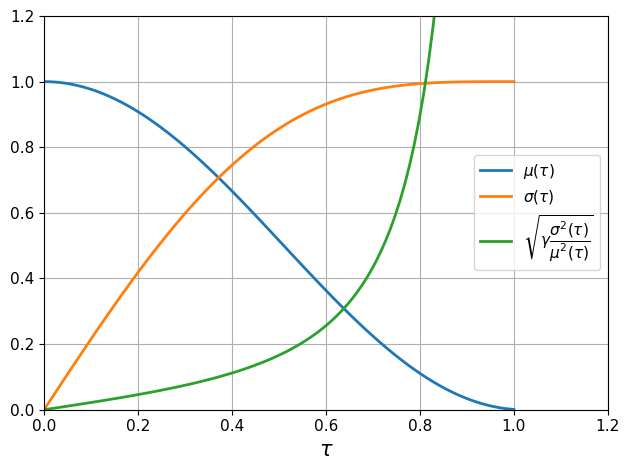

In [2]:
# Diffusion scheduling
eps = 1e-3
gam = 1e-2

def alpha(t):
    return torch.cos(math.acos(math.sqrt(eps))*t)**2

def mu(t):
    return alpha(t)

def sigma(t):
    return (1 - alpha(t)**2 + eps**2).sqrt()

def PLSvar(t):
    return gam*(sigma(t)**2)/(mu(t)**2)

t = torch.linspace(0,1,100)

plt.plot(t, mu(t), label = r'$\mu(\tau)$', linewidth = lw)
plt.plot(t, sigma(t), label = r'$\sigma(\tau)$', linewidth = lw)
plt.plot(t, PLSvar(t).sqrt(), label = r'$\sqrt{\gamma\dfrac{\sigma^2(\tau)}{\mu^2(\tau)}}$', linewidth = lw)
plt.ylim([0,1.2])
plt.xlim([0,1.2])
plt.xlabel(r'$\tau$', fontsize = axis_font)
plt.tick_params('both', labelsize = legend_font)
plt.grid()
plt.legend(fontsize = legend_font)
plt.tight_layout()
plt.savefig(impth+'scheduling.pdf')
plt.show()


tensor([[1., 0.],
        [0., 1.]])


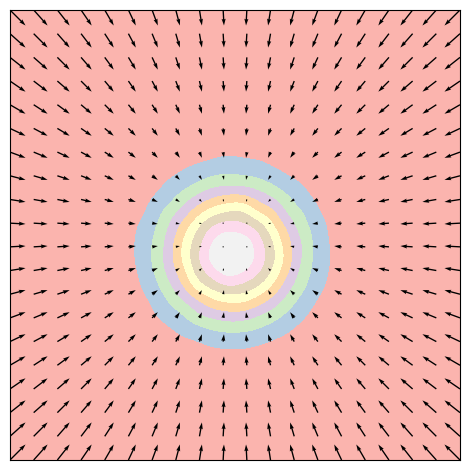

In [3]:
from torch.distributions import MultivariateNormal

sigm = torch.eye(2)
# sigm[0,1] = torch.rand(1)
# sigm[1,0] = torch.rand(1)

var = sigm@sigm.T
print(var)
dist = MultivariateNormal(torch.zeros(2), var)

s = dist.sample((2**20,))
h, _,_,_ = plt.hist2d(np.array(s[:,0]), np.array(s[:,1]), bins = 30)
plt.close()
plt.imshow(np.flip(h,1).T, interpolation = 'spline36', 
           extent = [-3*var[0,0],3*var[0,0],-3*var[1,1],3*var[1,1]],
           cmap = 'Pastel1')
x = torch.linspace(-3*var[0,0],3*var[0,0],20)
y = torch.linspace(-3*var[1,1],3*var[1,1],20)
a = plt.gca()
a.set_xticks(x)
a.set_yticks(y)
xy = torch.meshgrid(x,y,indexing = 'ij')

xyv = torch.cat([l.unsqueeze(0) for l in xy], dim = 0)
score = torch.linalg.inv(var)@((-xyv).reshape(2,-1))
score = score.reshape(2,20,20)
plt.quiver(xy[0], xy[1], score[0], score[1])
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.tight_layout()
plt.savefig(impth+'iso_score.pdf')
plt.show()


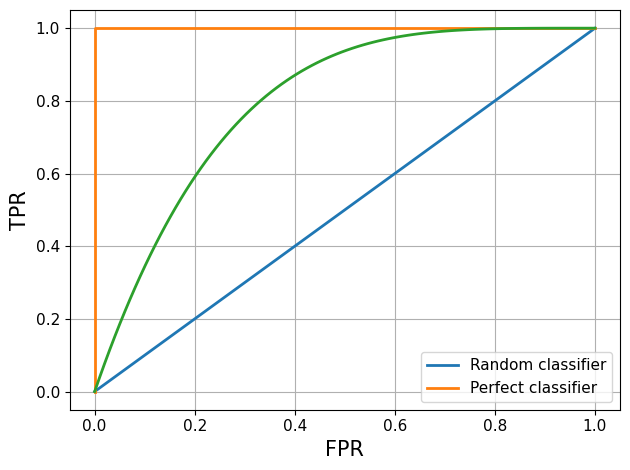

In [4]:
# ROC

x = torch.linspace(0,1,100)
y = torch.linspace(0,1,100)

plt.plot(x,y, label = 'Random classifier', linewidth = lw)
plt.plot([0,0,1],[0,1,1], label = 'Perfect classifier', linewidth = lw)
plt.plot(x,1-(1-x)**4, linewidth = lw)
plt.xlabel('FPR', fontsize = axis_font)
plt.ylabel('TPR', fontsize = axis_font)
plt.legend(fontsize = legend_font)
plt.grid()
plt.tick_params('both', labelsize = legend_font)
plt.tight_layout()
plt.savefig(impth+'AUROC.pdf')
plt.show()

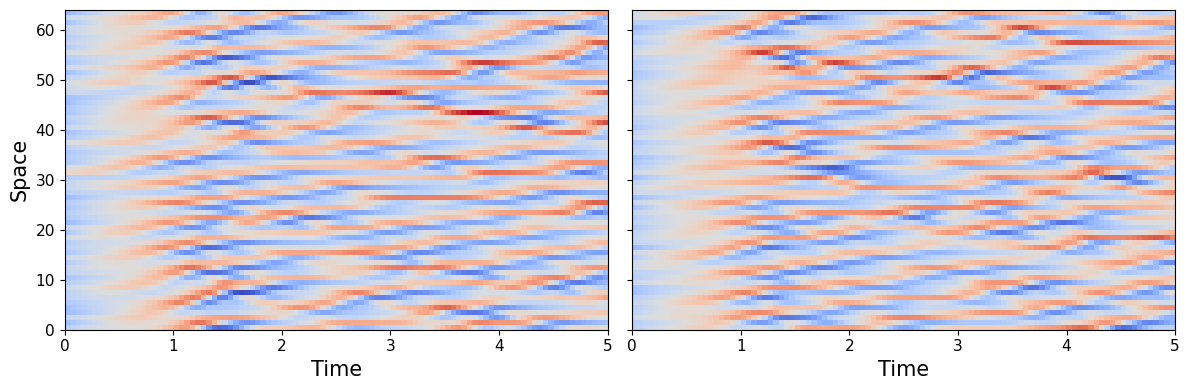

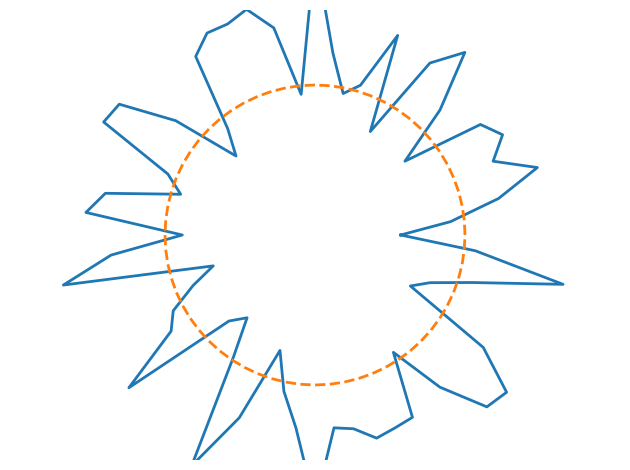

In [193]:
from dasbi.simulators.sim_lorenz96 import LZ96 as sim 

N = 64
s64 = sim(N, 8, .5)
times = torch.linspace(0,5,100)
s64.generate_steps(torch.randn((2,N)), times, observe=False)

fig,ax = plt.subplots(1,2, sharey='row', figsize = (12,4))

minv = torch.minimum(s64.data[0].min(),s64.data[1].min())
maxv = torch.maximum(s64.data[0].max(),s64.data[1].max())

ax[0].imshow(s64.data[0].T, cmap='coolwarm', extent = [0,5,0,N], aspect = 'auto', vmin = minv, vmax = maxv)
ax[1].imshow(s64.data[1].T, cmap='coolwarm', extent = [0,5,0,N], aspect = 'auto', vmin = minv, vmax = maxv)
ax[0].set_ylabel('Space', fontsize = axis_font)
ax[0].set_xlabel('Time', fontsize = axis_font)
ax[1].set_xlabel('Time', fontsize = axis_font)
ax[0].tick_params('both', labelsize = legend_font)
ax[1].tick_params('both', labelsize = legend_font)


plt.tight_layout()
plt.savefig(impth+'LZ96.pdf')

plt.show()

def polar_plot_lz(data, N, ensemble = False, offset = 10, gt = None, mask = None):
    th = torch.linspace(0,2*torch.pi,N+1)
    rad = offset
    
    if not ensemble:
        dispdat = torch.cat((data, data[:1]), dim = 0)
        plt.plot((rad + dispdat)*th.cos(), (rad + dispdat)*th.sin(), linewidth = lw)
        plt.plot(rad*th.cos(), rad*th.sin(), '--', linewidth = lw)

    else:
        width = 8*lw/data.shape[0]

        for d in data:
            d = d.squeeze()
            dispdat = torch.cat((d, d[:1]), dim = 0)
            plt.plot((rad + dispdat)*th.cos(), (rad + dispdat)*th.sin(), '0.7', linewidth = width, 
                     alpha = .1)     

        if mask is not None:
            for i,m in enumerate(mask.squeeze()):
                if m:
                    plt.plot([0, rad*th[i].cos()],[0, rad*th[i].sin()], 'g--', linewidth = lw)
        dispdat = torch.cat((gt, gt[:1]), dim = 0)
        plt.plot((rad + dispdat)*th.cos(), (rad + dispdat)*th.sin(), linewidth = lw)
        plt.plot(rad*th.cos(), rad*th.sin(), '--', linewidth = lw)       
    
    ax = plt.gca()
    ax.axis('equal')
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.gca().axis('off')
    plt.xlim(-rad-0.5*rad, rad+0.5*rad)
    plt.ylim(-rad-0.5*rad, rad+0.5*rad)
    plt.tight_layout()
    
polar_plot_lz(s64.data[0,50], N)


torch.Size([103, 64, 2, 32, 32])
torch.Size([1, 2, 32, 32])


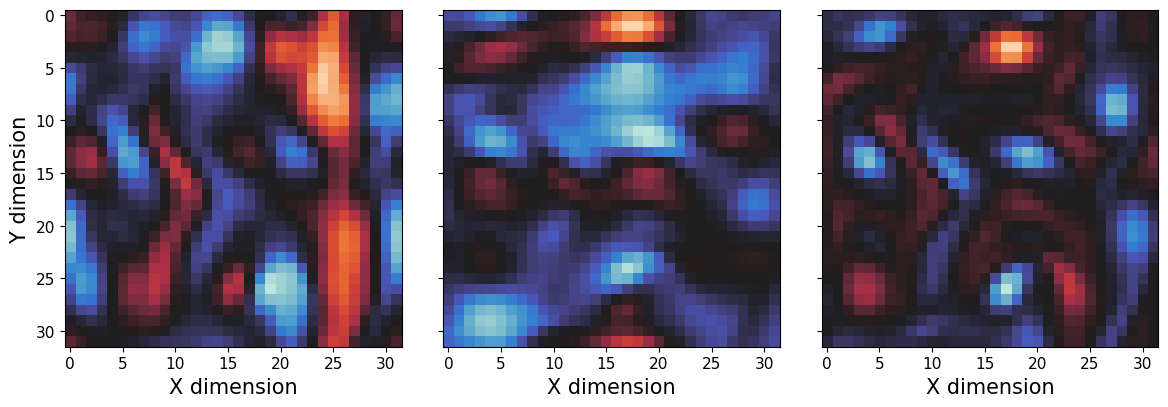

In [6]:
from KOLMO_LIN import vorticity, load_data
import seaborn as sns

color = sns.color_palette("icefire", as_cmap=True)
path_test = '../test.h5'
data = load_data(path_test)
print(data.shape)
data = data[0,torch.randint(64,(1,))]
print(data.shape)

fig,ax = plt.subplots(1,3, sharey='row', figsize = (12,4))

ax[0].imshow(data[0,0], cmap = color)
ax[1].imshow(data[0,1], cmap = color)
ax[2].imshow(vorticity(data[0]), cmap = color)

ax[0].set_ylabel('Y dimension', fontsize = axis_font)
ax[0].set_xlabel('X dimension', fontsize = axis_font)
ax[1].set_xlabel('X dimension', fontsize = axis_font)
ax[2].set_xlabel('X dimension', fontsize = axis_font)

ax[0].tick_params('both', labelsize = legend_font)
ax[1].tick_params('both', labelsize = legend_font)
ax[2].tick_params('both', labelsize = legend_font)

plt.tight_layout()
plt.savefig(impth+'KOLMO.pdf')

plt.show()


In [210]:
from LZ96_CONV import build, process_sim
import pickle 

def make_maf_lz_config(N,w):
    CONFIG = {
    # Architecture
    "embedding": 3,
    "hf": [32*int(N**0.5), ]*4,
    "tf": 3 + N//256,
    # Data
    "points": N,
    "noise": 0.5,
    "device": 'cuda',
    # Test with assimilation window
    "x_dim": (1, 1, N, 1),
    "y_dim": (1, w, N//4, 1),
    "y_dim_emb": (1, 11, N, 1),
    'obs_mask': True,
    "observer_fp": f"experiments/observer{N}LZ.pickle",
    }

    return CONFIG

def make_post_lz_config(N,w):
    dp = {
    8 : 2,
    16 : 2,
    32 : 2,
    64 : 3,
    128 : 3,
    256 : 4
    }

    CONFIG = {
    # Architecture
    "embedding": 3,
    "depth": dp[N],
    "input_h": 45 + int(np.log2(N)),
    # Data
    "points": N,
    "noise": 0.5,
    "device": 'cuda',
    # Test with assimilation window
    "x_dim": (1, 1, N, 1),
    "y_dim": (1, w, N//4, 1),
    "y_dim_emb": (1, 11, N, 1),
    'obs_mask': True, #+1 in y_dim
    "observer_fp": f"experiments/observer{N}LZ.pickle",
    }

    return CONFIG

def make_linp_lz_config(N,w):
    dp = {
        8 : 2,
        16 : 2,
        32 : 2,
        64 : 3,
        128 : 3,
        256 : 4
    }

    chan = {
        8 : 60,
        16 : 61,
        32 : 62,
        64 : 53,
        128 : 54,
        256 : 54
    }

    CONFIG = {
        # Architecture
        "embedding": 3,
        "depth": dp[N],
        "input_h": chan[N],
        # Data
        "points": N,
        "noise": 0.5,
        "device": 'cuda',
        # Test with assimilation window
        "x_dim": (1, 1, N, 1),
        "y_dim": (1, w, N//4, 1),
        "y_dim_emb": (1, 11, N, 1),
        'obs_mask': True, #+1 in y_dim
        "observer_fp": f"experiments/observer{N}LZ.pickle",
    }

    return CONFIG

def make_conv_lz_config(N,w):
    nms_dict = {
    8: 2,
    16: 2,
    32: 2,
    64: 3,
    128: 3,
    256: 4,
    }

    ms_mod = {
        8: 1,
        16: 1,
        32: 1,
        64: 2,
        128: 3,
        256: 4,
    }
    CONFIG = {
    # Architecture
    "embedding": 3,
    "kernel_size": 2,
    "ms_modules": ms_mod[N],
    "num_conv": 2,
    "N_ms": nms_dict[N],
    # Data
    "points": N,
    "noise": 0.5,
    "device": 'cuda',
    # Test with assimilation window
    "x_dim": (1, 1, N, 1),
    "y_dim": (1, w, N//4, 1),
    "y_dim_emb": (1, 11, N, 1),
    'obs_mask': True, #+1 in y_dim
    'ar': False, #+1 in y_dim_emb (for modargs not embnet)
    'roll':True,
    "observer_fp": f"experiments/observer{N}LZ.pickle",
    }

    return CONFIG

#DATA GENERATION
N = 256
observer_fp = f"experiments/observer{N}LZ.pickle"
# DATA
simsamp = sim(N, 8, .5)
times = torch.linspace(0,5,100)
with open(observer_fp, "rb") as handle:
    observer = pickle.load(handle)

simsamp.init_observer(observer)
simsamp.generate_steps(torch.randn((1024,N)), times)
mx, sx, my, sy, _,_ = process_sim(simsamp)

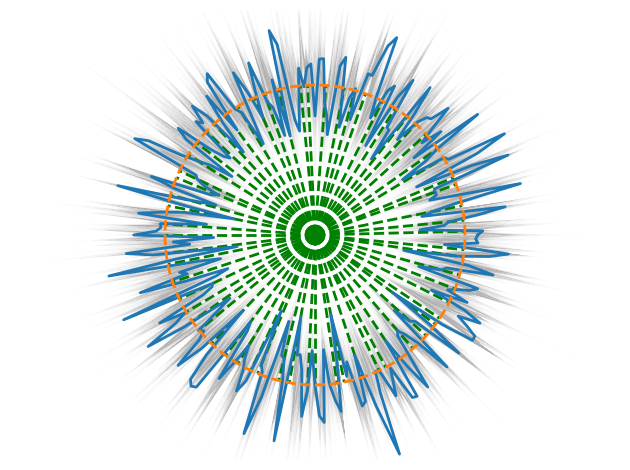

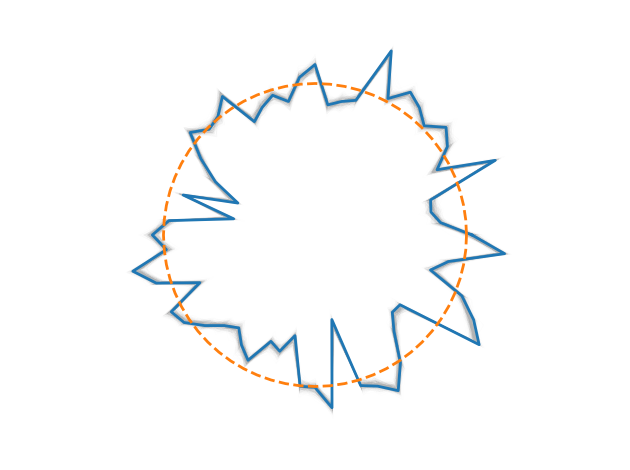

In [211]:
from LZ96_MAF import build
from lampe.plots import corner, mark_point

typeM = 'MAF'
samplerf = f'../checkpoints/LZ/{typeM}/step/{N}/2.pth'

time = 50
window = 1

CONFIG = make_maf_lz_config(N,window)

# Sampler
sampler = build(**CONFIG).to(CONFIG['device'])
with torch.no_grad():
    sampler(
        simsamp.data[None, None, 0, 0, :, None].to(CONFIG['device']),
        simsamp.obs[None, :window, 0, :, None].to(CONFIG['device']),
        simsamp.time[0, 0, None].to(CONFIG['device']),
    )
state = torch.load(f"{samplerf}", map_location=torch.device(CONFIG['device']))

sampler.load_state_dict(state)
sampler.eval()

x_star, y_star, t_star = simsamp.data[0,time], simsamp.obs[0,time], simsamp.time[0,time]
# pplz = lambda x,n:polar_plot_lz(x,n,offset=4)

pplz_samp = lambda x,n,gt,m:polar_plot_lz(x,n,offset=5, ensemble=True, gt = gt, mask = m)

with torch.no_grad():
    y_star = y_star[None, None, :,None].to(CONFIG['device'])
    t_star = t_star.unsqueeze(-1)
    xs = sampler.sample(y_star,t_star.to(CONFIG['device']), 512).cpu()
    pplz_samp(xs, N, gt = x_star, m = observer.get_mask())
    plt.savefig(impth+f'{typeM}_pred_state.pdf')
    plt.show()
    # CHANGE xs.unsqueeze(-1) for MAF
    ys = (observer.observe(xs.unsqueeze(-1)*sx + mx).squeeze(-1) -my)/sy
    pplz_samp(ys, N//4, gt = y_star.squeeze().cpu(), m=None)
    plt.savefig(impth+f'{typeM}_pred_obs.pdf')
    plt.show()

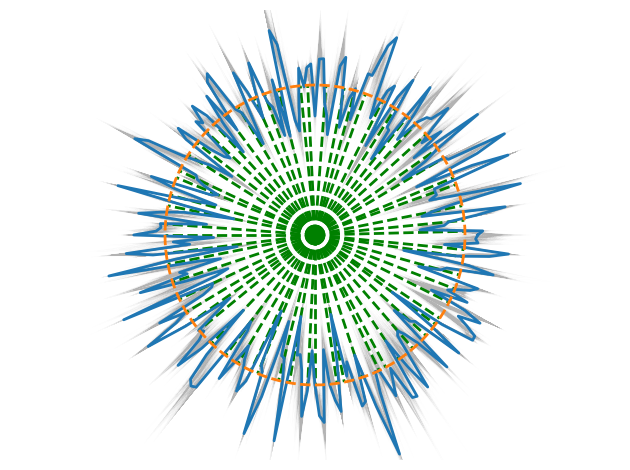

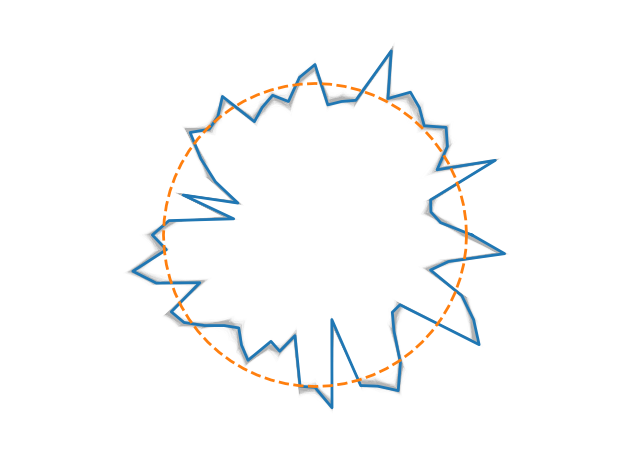

In [212]:
#does not change data

samplerf = f'../checkpoints/LZ/{typeM}/assim/{N}/2.pth'

window = 10

CONFIG = make_maf_lz_config(N,window)

# Sampler
sampler = build(**CONFIG).to(CONFIG['device'])
with torch.no_grad():
    sampler(
        simsamp.data[None, None, 0, 0, :, None].to(CONFIG['device']),
        simsamp.obs[None, :window, 0, :, None].to(CONFIG['device']),
        simsamp.time[0, 0, None].to(CONFIG['device']),
    )
state = torch.load(f"{samplerf}", map_location=torch.device(CONFIG['device']))

sampler.load_state_dict(state)
sampler.eval()

x_star, y_star, t_star = simsamp.data[0,time], simsamp.obs[0,time-9:time+1], simsamp.time[0,time]
pplz_samp = lambda x,n,gt,m:polar_plot_lz(x,n,offset=5, ensemble=True, gt = gt,mask = m)

with torch.no_grad():
    y_star = y_star[None, ...,None].to(CONFIG['device'])
    t_star = t_star.unsqueeze(-1)
    xs = sampler.sample(y_star,t_star.to(CONFIG['device']), 512).cpu()
    pplz_samp(xs, N, gt = x_star,m = observer.get_mask())
    plt.savefig(impth+f'{typeM}_pred_state_assim.pdf')
    plt.show()
    # CHANGE xs.unsqueeze(-1) for MAF
    ys = (observer.observe(xs.unsqueeze(-1)*sx + mx).squeeze(-1) -my)/sy
    pplz_samp(ys, N//4, gt = y_star.squeeze()[-1].cpu(),m = None)
    plt.savefig(impth+f'{typeM}_pred_obs_assim.pdf')
    plt.show()

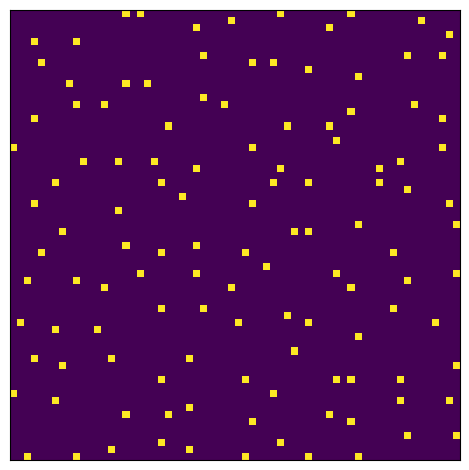

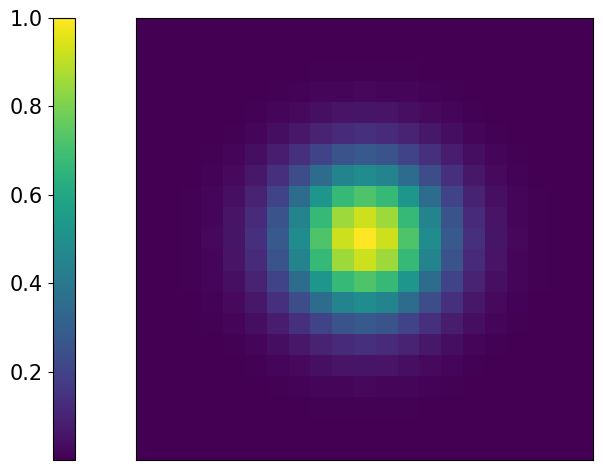

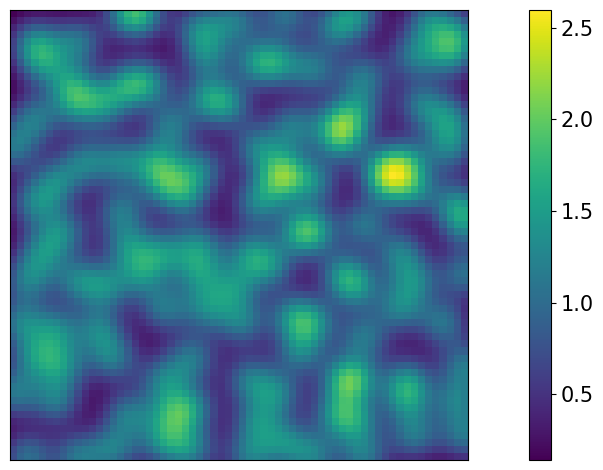

torch.Size([16, 32])


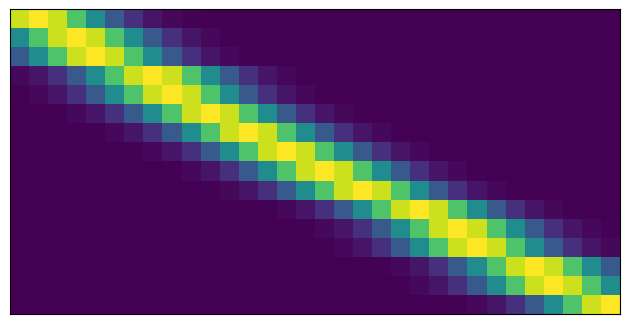

In [172]:
from dasbi.simulators.observators.observator2D import ObservatorStation2D as obs

o = obs((64, 64), (5, 5), (1, 1), (10, 10), (2.5, 2.5))
# o.visualize()

stat = o.get_mask()
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.tight_layout()
plt.imshow(stat)
plt.savefig(impth+'Stations.pdf',bbox_inches='tight')
plt.show()

eval_grid = torch.meshgrid(
            torch.arange(-o.aoe[0], o.aoe[0] + 1),
            torch.arange(-o.aoe[1], o.aoe[1] + 1),
            indexing="xy",
        )
eval_grid = torch.cat([X.unsqueeze(-1) for X in eval_grid], dim=-1)

gaussian_kernel = o.gaussian_2D(
    torch.zeros(2), torch.tensor(o.spf), eval_grid
)
gaussian_kernel = (gaussian_kernel / torch.max(gaussian_kernel)).T
plt.imshow(gaussian_kernel, aspect = 'auto')
cb=plt.colorbar(location = 'left', pad = 0.1)
cb.ax.tick_params(labelsize = axis_font)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.tight_layout()
plt.savefig(impth+'Kernel.pdf',bbox_inches='tight')
plt.show()
plt.close()
plt.clf()

importance = o.observe(None, True)
plt.imshow(importance[:, :], aspect = 'auto')
cb = plt.colorbar(pad = 0.1)
cb.ax.tick_params(labelsize = axis_font)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.tight_layout()
plt.savefig(impth+'ImportanceMap.pdf',bbox_inches='tight')
plt.show()

o = obs((32, 32), (2, 2), (0, 0), (10, 10), (2.5, 2.5))
print(o.get_Obs_mat().shape)
plt.imshow(o.get_Obs_mat())
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.tight_layout()
plt.savefig(impth+'operatorMat.pdf',bbox_inches='tight')
plt.show()